# 3. Community Detection

In [2]:
import praw
import pandas as pd
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx

# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_comments = pd.read_csv('../data/comments_graph_general_top30percent_clean.csv')
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))

In [3]:

def community_detection(G, c):
    # number of communities
    print("Number of communities: ", len(c), end="\n\n")

    # size of communities
    community_sizes = [len(community) for community in c]
    for i, size in enumerate(community_sizes, 1):
        print(f"Community {i:>2}: Size {size}")

    # modularity
    print(f"\nModularity: {nx.community.modularity(G, c):.4f}")

    ######
    # create a DataFrame node-community
    l=[]
    i=0

    for community in c:
        for node in community:
            l.append([node,i])
        i+=1

    df= pd.DataFrame(l,columns=['node','community'])
    df.sort_values(by='node',inplace=True)
    df.reset_index(drop=True,inplace=True)

    return df


In [5]:
pos = nx.spring_layout(G, iterations=50)


### Greedy modularity

In [4]:
c_greedy = nx.community.greedy_modularity_communities(G)
df_greedy = community_detection(G, c_greedy)
display(df_greedy.head(7))

Number of communities:  197

Community  1: Size 3164
Community  2: Size 1071
Community  3: Size 624
Community  4: Size 422
Community  5: Size 400
Community  6: Size 376
Community  7: Size 314
Community  8: Size 254
Community  9: Size 233
Community 10: Size 221
Community 11: Size 194
Community 12: Size 187
Community 13: Size 158
Community 14: Size 119
Community 15: Size 103
Community 16: Size 83
Community 17: Size 81
Community 18: Size 80
Community 19: Size 67
Community 20: Size 67
Community 21: Size 61
Community 22: Size 40
Community 23: Size 27
Community 24: Size 19
Community 25: Size 18
Community 26: Size 13
Community 27: Size 13
Community 28: Size 12
Community 29: Size 8
Community 30: Size 8
Community 31: Size 7
Community 32: Size 7
Community 33: Size 6
Community 34: Size 6
Community 35: Size 5
Community 36: Size 5
Community 37: Size 5
Community 38: Size 5
Community 39: Size 5
Community 40: Size 5
Community 41: Size 5
Community 42: Size 5
Community 43: Size 5
Community 44: Size 4
Co

,node,community
0,-1-1-1-1-1-1,9
1,-Boobs_,10
2,-Champloo-,5
3,-DIrty__MARtini-,3
4,-En_RiKa09-,11
5,-Fella-,29
6,-Fletcher-,14


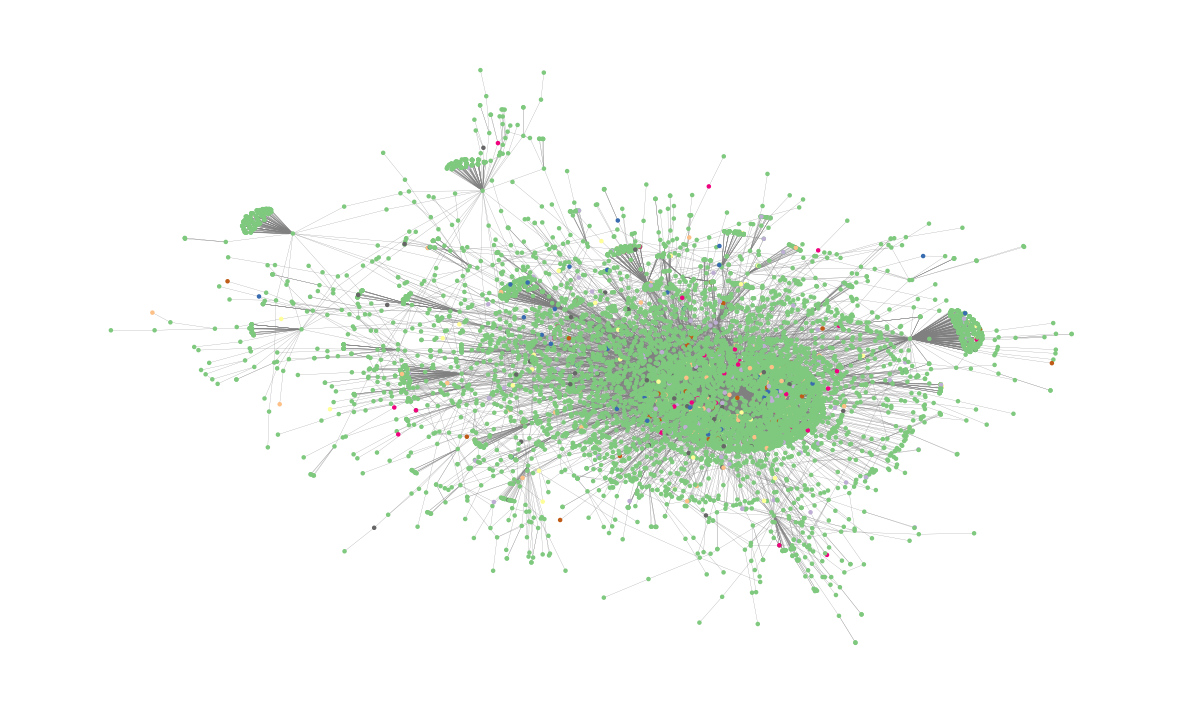

In [11]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_greedy['community'], cmap=plt.cm.Accent, edge_color='gray', node_size=5, with_labels=False, width=0.15)

### Louvain

Number of communities:  54

Community  1: Size 124
Community  2: Size 461
Community  3: Size 124
Community  4: Size 164
Community  5: Size 173
Community  6: Size 65
Community  7: Size 346
Community  8: Size 157
Community  9: Size 148
Community 10: Size 3
Community 11: Size 112
Community 12: Size 3
Community 13: Size 561
Community 14: Size 4
Community 15: Size 98
Community 16: Size 34
Community 17: Size 3
Community 18: Size 69
Community 19: Size 407
Community 20: Size 148
Community 21: Size 3
Community 22: Size 20
Community 23: Size 315
Community 24: Size 104
Community 25: Size 61
Community 26: Size 213
Community 27: Size 162
Community 28: Size 3
Community 29: Size 6
Community 30: Size 3
Community 31: Size 3
Community 32: Size 5
Community 33: Size 264
Community 34: Size 157
Community 35: Size 186
Community 36: Size 111
Community 37: Size 5
Community 38: Size 92
Community 39: Size 256
Community 40: Size 5
Community 41: Size 3
Community 42: Size 7
Community 43: Size 3
Community 44: Size 4

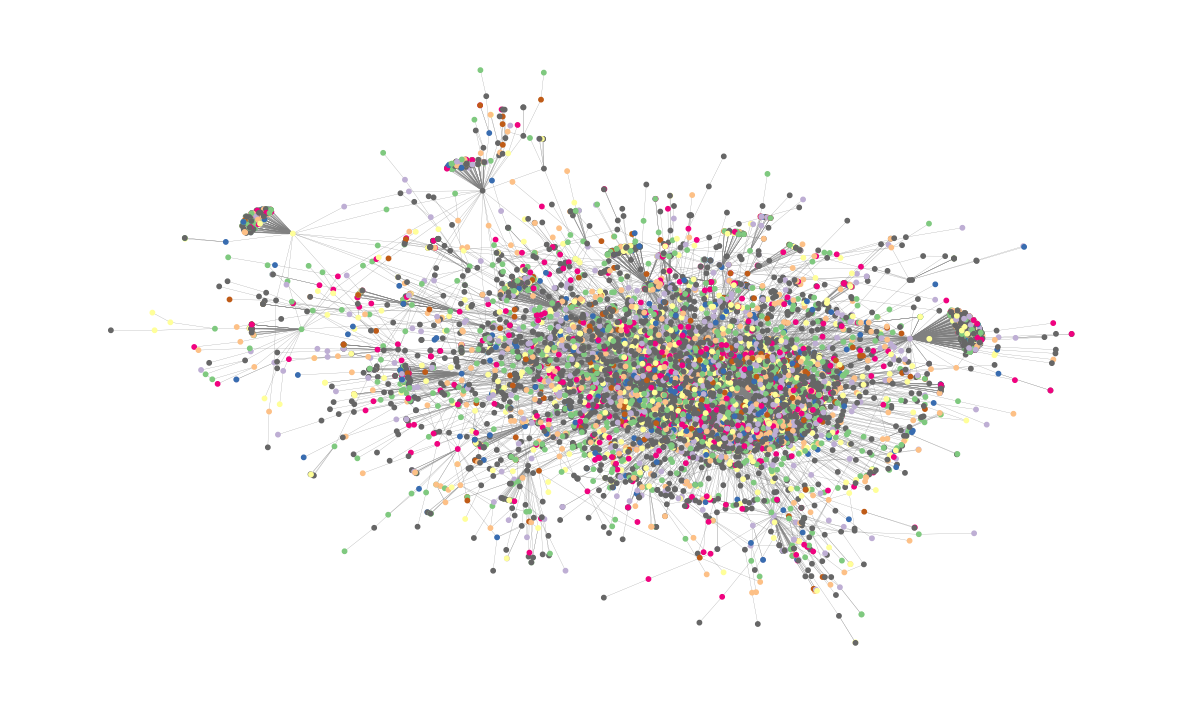

In [12]:
c_louvain = nx.community.louvain_communities(G)
df_louvain = community_detection(G, c_louvain)

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_louvain['community'], cmap=plt.cm.Accent, edge_color='gray', node_size= 10, with_labels= False, width= 0.15)

### FluidC

In [15]:
for k in range(1, 26):
    c = list(nx.community.asyn_fluidc(G, k))
    modularity = nx.community.modularity(G, c)
    print(f"#communities = {k}, Modularity = {modularity:.4f}")

#communities = 1, Modularity = 0.0000
#communities = 2, Modularity = 0.3515
#communities = 3, Modularity = 0.4705
#communities = 4, Modularity = 0.5421
#communities = 5, Modularity = 0.5184
#communities = 6, Modularity = 0.5281
#communities = 7, Modularity = 0.4897
#communities = 8, Modularity = 0.6241
#communities = 9, Modularity = 0.4458
#communities = 10, Modularity = 0.5483
#communities = 11, Modularity = 0.5562
#communities = 12, Modularity = 0.4819
#communities = 13, Modularity = 0.6422
#communities = 14, Modularity = 0.5281
#communities = 15, Modularity = 0.5188
#communities = 16, Modularity = 0.4775
#communities = 17, Modularity = 0.4534
#communities = 18, Modularity = 0.4842
#communities = 19, Modularity = 0.4796
#communities = 20, Modularity = 0.4714
#communities = 21, Modularity = 0.5054
#communities = 22, Modularity = 0.4884
#communities = 23, Modularity = 0.5046
#communities = 24, Modularity = 0.4746
#communities = 25, Modularity = 0.4538


Number of communities:  13

Community  1: Size 870
Community  2: Size 827
Community  3: Size 2
Community  4: Size 952
Community  5: Size 822
Community  6: Size 485
Community  7: Size 776
Community  8: Size 824
Community  9: Size 756
Community 10: Size 327
Community 11: Size 868
Community 12: Size 840
Community 13: Size 513

Modularity: 0.4631


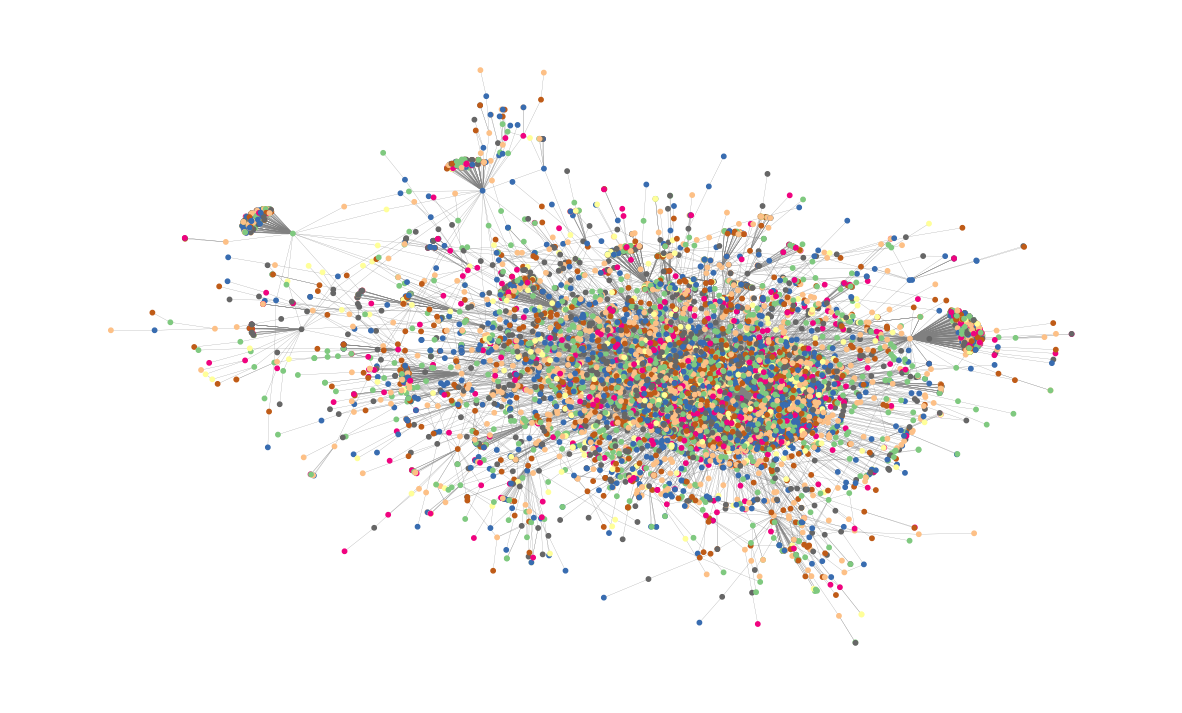

In [16]:
top_k = 13
c_fluidc = list(nx.community.asyn_fluidc(G, k=top_k))
df_fluidc = community_detection(G, c_fluidc)

fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_color=df_fluidc['community'], cmap=plt.cm.Accent, edge_color='gray', node_size= 10, with_labels= False, width= 0.15)

Clearly fluidc is not suited when we have a big difference in size between clusters.